In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [2]:
iris_df=pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data",header=None)
iris_df.columns = ['x1', 'x2', 'x3', 'x4', 'y']
iris_type=iris_df["y"].unique()
y=iris_df["y"].copy()
a=0
for i in iris_type:
    y[y==i]=a
    a=a+1
iris_df["y"]=y.astype("float32")
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
x1    150 non-null float64
x2    150 non-null float64
x3    150 non-null float64
x4    150 non-null float64
y     150 non-null float32
dtypes: float32(1), float64(4)
memory usage: 5.4 KB


In [3]:
X=torch.tensor(iris_df.iloc[:,0:4].values,dtype=torch.float32)
y=torch.tensor(iris_df["y"].values,dtype=torch.int64)
torch.manual_seed(123)
shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
X,y=X[shuffle_idx],y[shuffle_idx]
train_split=int(y.size(0)*0.7)
X_train,y_train,X_test,y_test=X[:train_split],y[:train_split],X[train_split:],y[train_split:]

X_train=(X_train-X_train.min(dim=0)[0])/(X_train.max(dim=0)[0]-X_train.min(dim=0)[0])
X_test=(X_test-X_test.min(dim=0)[0])/(X_test.max(dim=0)[0]-X_test.min(dim=0)[0])

In [4]:
class softmaxregression(torch.nn.Module):
    def __init__(self, num_features,num_classes):
        super(softmaxregression, self).__init__()
        self.linear = torch.nn.Linear(num_features, num_classes)

    def forward(self, x):
        logits = self.linear(x)
        probs = F.softmax(logits, dim=1)
        return logits,probs

def train(model, x, y, num_epochs,
          learning_rate=0.01, minibatch_size=10):
    
    cost = []
    
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    for e in range(num_epochs):
        
        shuffle_idx = torch.randperm(y.size(0), dtype=torch.long)
        minibatches = torch.split(shuffle_idx, minibatch_size)
        
        for minibatch_idx in minibatches:

            logits,probs = model(x[minibatch_idx])
            
            loss = F.cross_entropy(logits, y[minibatch_idx])
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
        
        with torch.no_grad():
            logits,probs = model(x)
            curr_loss = F.cross_entropy(logits, y)
            cost.append(curr_loss)

    return cost

def test(model,x,y):
    with torch.no_grad():
        logits, probs = model(x)
        _, predicted_labels = torch.max(probs, 1)
        correct_pred = (predicted_labels == y).sum()
        accuracy=(correct_pred/y.size(0))*100
    return accuracy

tensor(97.7778)
tensor(97.1429)


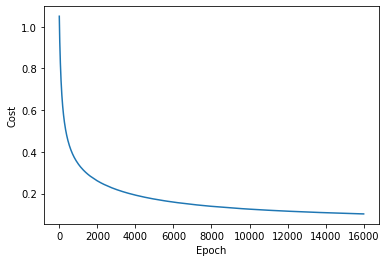

In [5]:
model = softmaxregression(num_features=4, num_classes=3)
cost=train(model,X_train,y_train,num_epochs=16000,minibatch_size=10)
test_accuracy=test(model,X_test,y_test)
train_accuracy=test(model,X_train,y_train)
plt.plot(cost)
plt.ylabel('Cost')
plt.xlabel('Epoch')
print(test_accuracy)
print(train_accuracy)